### PA3: Hugging Face Transformers

In [ ]:
!pip3 install transformers[torch] accelerate -U

In [ ]:
!pip3 install transformers datasets evaluate rouge_score py7zr

Using "SAMsum" dataset to perform the summarization task.

In [ ]:
from datasets import load_dataset
samsum = load_dataset("samsum")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### 2. Exploratory Data Analysis

Initial exploration of data to gain insights about dialogues and summaries

The dataset samsum is split into three splits: train, test and validation.

In [ ]:
print(samsum)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})


In [ ]:
print(samsum['train'][:5])

{'id': ['13818513', '13728867', '13681000', '13730747', '13728094'], 'dialogue': ["Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)", 'Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great', "Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style", "Edward: Rachel, I think I'm in ove with Bella..\r\nrachel: Dont say anything else..\r\nEdward: What do you mean??\r\nrachel: Open your fu**ing d

a) Characteristics of dialogues and summaries

Importing all the necessary libraries for understanding data

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

We can print all the columns of data as a dataframe from the dataset by concatenating all the splits(i.e., train, test, split).

In [ ]:
df_train = pd.DataFrame(samsum['train'])
df_test = pd.DataFrame(samsum['test'])
df_val = pd.DataFrame(samsum['validation'])

df = pd.concat([df_train, df_test, df_val], axis = 0)
df.head(5)

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


Checking for null values in dataset

In [ ]:
print(df.isnull().sum())

id          0
dialogue    0
summary     0
dtype: int64


Calculating the length of each dialogues and summaries in the dataset

In [ ]:
dialogue_length=[len(dialogue.split()) for dialogue in df['dialogue']]
summary_length= [len(summary.split()) for summary in df['summary'] ]

Converting the length values from list to tensors

In [ ]:
dialogue_tensor = torch.tensor(dialogue_length)
summary_tensor = torch.tensor(summary_length)

Using torch library to calculate the mean and standard deviation length of the dialogues present in the samsum dataset.

In [ ]:
mean_dialogue_length = torch.mean(dialogue_tensor.float())
print(f"Mean length of dialogues: {mean_dialogue_length}")
mean_summary_length = torch.mean(summary_tensor.float())
print(f"Mean length of summaries: {mean_summary_length}")

Mean length of dialogues: 93.76535034179688
Mean length of summaries: 20.300750732421875


In [ ]:
std_dialogue_length = torch.std(dialogue_tensor.float())
print(f"Standard Deviation of dialogue lengths: {std_dialogue_length}")
std_summary_length = torch.std(summary_tensor.float())
print(f"Standard Deviation of summaries: {std_summary_length}")

Standard Deviation of dialogue lengths: 74.11382293701172
Standard Deviation of summaries: 11.13180923461914


In [ ]:
dialogue_summary_lengths = list(zip(dialogue_length, summary_length))
dialogue_summary_lengths_tensor = torch.tensor(dialogue_summary_lengths)

b) Plot of distributions of dialogues and summaries

The following scatter plot shows the correlation between length of the dialogue to length of the summary. The correlation between the length of dialogue to length of summary is 0.6

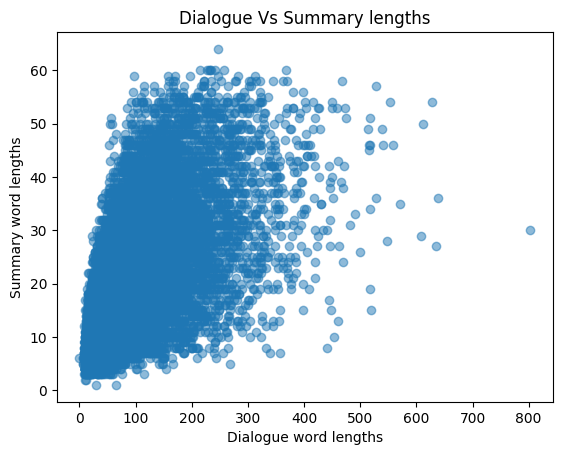

In [ ]:
plt.scatter(dialogue_length, summary_length, alpha = 0.5)
plt.title("Dialogue Vs Summary lengths")
plt.xlabel("Dialogue word lengths")
plt.ylabel("Summary word lengths")
plt.show()

In [ ]:
correlation = torch.corrcoef(dialogue_summary_lengths_tensor.T)
print(f"Correlation between Dialogue and Summary lengths is: {correlation[0, 1]}")

Correlation between Dialogue and Summary lengths is: 0.6044240593910217


c) 20 most common words in the dialogues and their frequencies

In [ ]:
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The first 20 common words are mostly stopwords(words that do not have significant meaning on its own). Using nltk package to remove the stopwords.

In [ ]:
def preprocess(text):
  text = text.lower()
  text = text.translate(str.maketrans('','', string.punctuation))
  words = text.split()
  return words

def preprocess_without_stopwords(text):
  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation))
  words = text.split()
  stop_words = set(stopwords.words('english'))
  main_words = [word for word in words if word not in stop_words]
  return main_words

In [ ]:
words = df['dialogue'].apply(preprocess).explode().tolist()
words_freq = Counter(words)
common_words = words_freq.most_common(20)
df_common_words = pd.DataFrame(common_words, columns = ['Word', 'Frequency'])
print(df_common_words)

words_main = df['dialogue'].apply(preprocess_without_stopwords).explode().tolist()
words_main_freq = Counter(words_main)
common_main_words = words_main_freq.most_common(20)
df_common_main_words = pd.DataFrame(common_main_words, columns =['Word_main', 'Frequency'])
print(df_common_main_words)

    Word  Frequency
0      i      48950
1    you      43240
2    the      35050
3     to      32321
4      a      24709
5     it      22618
6    and      19714
7    for      13322
8     in      12832
9     is      12613
10  that      12095
11  have      11977
12    of      11915
13    so      11603
14   but      11329
15    me      11297
16    be      10203
17  what       9670
18    im       9630
19    we       9573
   Word_main  Frequency
0         im       9630
1       know       8352
2         ok       6934
3       dont       6917
4       like       6274
5       good       5163
6        ill       5000
7      think       4862
8       yeah       4828
9        see       4778
10      well       4765
11       yes       4690
12      time       4591
13      sure       4469
14       one       4335
15        go       4280
16    really       4195
17       get       4188
18     thats       3616
19      need       3524


### 3. Inference with Pre-trained Models

a) The pre-trained models

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

First Pre-trained model: Bart by facebook

In [ ]:
bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

Second Pre-trained model: T5

In [ ]:
t5_tokeinzer = AutoTokenizer.from_pretrained("t5-large")
t5_model = AutoModelForSeq2SeqLM.from_pretrained("t5-large")

Third Pretrained-model: Google's Pegasus

In [ ]:
pegasus_tokenizer = AutoTokenizer.from_pretrained("google/pegasus-large")
pegasus_model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-large")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


b) Using the above models to generate the summary of sample dialogues

In [ ]:
if torch.cuda.is_available():
   torch.cuda.empty_cache()

In [ ]:
from transformers import pipeline

Sample dialogues from the dataset

In [ ]:
sample_dialogues = samsum['test']['dialogue'][:5]
for i, dialogue in enumerate(sample_dialogues, start=1):
    print(f"Dialogue {i}:\n{dialogue}\n{'='*50}\n")


Dialogue 1:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Dialogue 2:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Dialogue 3:
Lenny: Babe, can you help me with something?
Bob: Sure, what's up?
Lenny: Which one should I pick?
Bob: Send 

Using bart to generate summarization for the sample examples.

In [ ]:
bart_summarizer = pipeline(task= "summarization", model = bart_model, tokenizer = bart_tokenizer, max_length = 60, device = 0 if torch.cuda.is_available() else -1)
bart_summary = [bart_summarizer(dialogue)[0]['summary_text'] for dialogue in sample_dialogues]

In [ ]:
for i, dialogue in enumerate(sample_dialogues):
    print(f"Dialogue {i+1}:")
    print(dialogue)
    print("\nBART Summary:")
    print(bart_summary[i])
    print("\n" + "="*50 + "\n")


Dialogue 1:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

BART Summary:
Hannah asks Amanda for Betty's number. Amanda can't find it. Hannah asks Larry. Amanda asks Larry to text him. Hannah says she'll text him back. Hannah calls it a day and says she's going to go home. Hannah: "Bye bye"


Dialogue 2:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups

Using T5 to generate summarization fror the sample examples.

In [ ]:
t5_summarizer = pipeline(task="summarization", model = t5_model, tokenizer = t5_tokeinzer,max_length = 60,device = 0 if torch.cuda.is_available() else -1)
t5_summary = [t5_summarizer(dialogue)[0]['summary_text'] for dialogue in sample_dialogues]

In [ ]:
for i, dialogue in enumerate(sample_dialogues):
    print(f"Dialogue {i+1}:")
    print(dialogue)
    print("\nT5 Summary:")
    print(t5_summary[i])
    print("\n" + "="*50 + "\n")

Dialogue 1:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

T5 Summary:
Hannah: hey, do you have Betty's number? Amanda: ask Larry Amanda: he called her last time we were at the park together Hannah: don't be shy, he's very nice .


Dialogue 2:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eri

Using Pegasus to generate summarization fror the sample examples.

In [ ]:
pegasus_summarizer = pipeline(task="summarization", model = pegasus_model, tokenizer = pegasus_tokenizer, max_length = 60, device = 0 if torch.cuda.is_available() else -1)
pegasus_summary = [pegasus_summarizer(dialogue)[0]['summary_text'] for dialogue in sample_dialogues]

In [ ]:
for i, dialogue in enumerate(sample_dialogues):
    print(f"Dialogue {i+1}:")
    print(dialogue)
    print("\nPegasus Summary:")
    print(pegasus_summary[i])
    print("\n" + "="*50 + "\n")

Dialogue 1:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Pegasus Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together Hannah: I don't know him well Hannah: file_gif> Amanda: Don't be shy, he's very nice Hannah: If you say so..


Dialogue 2:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'l

In [ ]:
!pip3 install evaluate

Calculating the ROUGE score for all the pre-trained models.

In [ ]:
import evaluate
rogue = evaluate.load('rouge')

# Use a sample dialogue and summary for evaluation
generated_summary = pegasus_summary[0]
reference_summary = samsum['test']['summary'][0]  # Use corresponding summary from test set

# Compute ROUGE scores
results1 = rogue.compute(predictions=[generated_summary], references=[reference_summary])
print("ROUGE Scores:")
print(results1)

ROUGE Scores:
{'rouge1': 0.1818181818181818, 'rouge2': 0.0, 'rougeL': 0.1090909090909091, 'rougeLsum': 0.1090909090909091}


In [ ]:
# Use a sample dialogue and summary for evaluation
generated_summary = bart_summary[0]
reference_summary = samsum['test']['summary'][0]  # Use corresponding summary from test set

# Compute ROUGE scores
results2= rogue.compute(predictions=[generated_summary], references=[reference_summary])
print("ROUGE Scores:")
print(results2)

ROUGE Scores:
{'rouge1': 0.3333333333333333, 'rouge2': 0.06896551724137931, 'rougeL': 0.3, 'rougeLsum': 0.3}


In [ ]:
# Use a sample dialogue and summary for evaluation
generated_summary = t5_summary[0]
reference_summary = samsum['test']['summary'][0]  # Use corresponding summary from test set

# Compute ROUGE scores
results3 = rogue.compute(predictions=[generated_summary], references=[reference_summary])
print("ROUGE Scores:")
print(results3)

ROUGE Scores:
{'rouge1': 0.3333333333333333, 'rouge2': 0.08695652173913043, 'rougeL': 0.25, 'rougeLsum': 0.25}


### 4. Fine-Tuning:

a) Fine-tuning T5 model(small)

Checking the configuration of the base t5 small configuration.

In [ ]:
from transformers import AutoConfig


print(AutoConfig.from_pretrained("t5-small"))

T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
     

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


b) Preprocessing the data to tokenize the dialogues and their summaries.

In [ ]:
def preprocess_function(examples):
    inputs = examples["dialogue"]
    targets = examples["summary"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=150, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing
tokenized_datasets = samsum.map(preprocess_function, batched=True)

c) Training the model and applying various hyperparameters.

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Use eval_strategy instead of evaluation_strategy
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps = 16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    fp16 = True,
)

# Define data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
0,1.943700,1.763243
1,1.909900,1.717964
2,1.868200,1.704341


TrainOutput(global_step=2760, training_loss=1.9564946305924567, metrics={'train_runtime': 3299.7827, 'train_samples_per_second': 13.394, 'train_steps_per_second': 0.836, 'total_flos': 1725362661752832.0, 'train_loss': 1.9564946305924567, 'epoch': 2.997556339940266})

d) Calculating the ROUGE scores of fine-tuneed model.

In [ ]:
import evaluate

rouge = evaluate.load('rouge')


def generate_summary(dialogue):
    inputs = tokenizer(dialogue, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs.input_ids.to(model.device), max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

sample_dialogues = samsum['test']['dialogue'][:5]


generated_summaries = [generate_summary(dialogue) for dialogue in sample_dialogues]


for i, (dialogue, summary) in enumerate(zip(sample_dialogues, generated_summaries), start=1):
    print(f"Dialogue {i}:\n{dialogue}\n{'='*50}\n")
    print(f"Fine-tuned Model Summary:\n{summary}\n{'='*50}\n")




Dialogue 1:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Fine-tuned Model Summary:
Amanda has Betty's number. He called her last time she was at the park together.

Dialogue 2:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Fine-tuned Mo

In [ ]:
test_dialogues = samsum['test']['dialogue'][:5]
test_summaries = samsum['test']['summary'][:5]

generated_summaries = [generate_summary(dialogue) for dialogue in test_dialogues]
results = rouge.compute(predictions=generated_summaries, references=test_summaries)
print(results)


{'rouge1': 0.33965092667037744, 'rouge2': 0.1011832611832612, 'rougeL': 0.27518760178943247, 'rougeLsum': 0.27528748428061933}


5. Evaluation and Analysis

a) Comparing Rouge scores of fine-tuned models and pre fine-tuned models.

In [ ]:
print(f"Pegasus rogue scores{results1}")
print(f"Bart Rogue scores{results2}")
print(f"T5 Rogue scores {results3}")

fine_tuned_results = rouge.compute(predictions=generated_summaries, references=test_summaries)
print("Fine-tuned Model ROUGE Scores:", fine_tuned_results)


Pegasus rogue scores{'rouge1': 0.1818181818181818, 'rouge2': 0.0, 'rougeL': 0.1090909090909091, 'rougeLsum': 0.1090909090909091}
Bart Rogue scores{'rouge1': 0.3333333333333333, 'rouge2': 0.06896551724137931, 'rougeL': 0.3, 'rougeLsum': 0.3}
T5 Rogue scores {'rouge1': 0.3333333333333333, 'rouge2': 0.08695652173913043, 'rougeL': 0.25, 'rougeLsum': 0.25}
Fine-tuned Model ROUGE Scores: {'rouge1': 0.33965092667037744, 'rouge2': 0.1011832611832612, 'rougeL': 0.27518760178943247, 'rougeLsum': 0.27528748428061933}


b) Fine-tuning model's fluency and coherence.

The fine-tuned model is "t5-small" due to the memorty issues we are using the smallest versions. Though it outperforms the default pre-trained models on the rogue score very slightly. These fine-tune models can achieve high fluency and coherence if bart higher parameters model was fine-tuned. The current model still summarizes individual dialogues instead of the summary of the dialogues which can be improved using powerful models like bart.